# Trend Finder
This notebook tries to identify trends in a crypto chart which indicate buy or sell signals to be used for automated trading. This is done by (1) creating a feature matrix which is (2) used as input for a deep learning network based on TensorFlow.
See the following video regarding the used TensorFlow approach: https://www.youtube.com/watch?v=-vHQub0NXI4
The used data sets have been downloaded from this site: https://www.cryptodatadownload.com/data/gemini/

In [1]:
# Import python libraries
from statistics import mean
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import seaborn as sns
from collections import defaultdict
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from IPython import display
%matplotlib inline

In [2]:
# Parameters
create_new_feature_matrix = True             # If True, create new file, otherwise try to load existing file with fitting name
create_new_model = True                      # If True, train model, otherwise load existing one with fitting file name

feature_matrix_logarithmized = True          # If True, use log values for relative growth (not for price)
                                             # If no new matrix is created, this feature is not applied.

chart_path = './'                            # Path of the chart to be used for training
chart_name = 'ETH_concat_chart.csv'          # File name of the chart to be used for training
number_of_epochs = 50                        # Number of epoch for training of the deep learning model
prediction_label = 'Next8192'                # Prediction label (predict the growth till price in x cycles)

use_last_fraction_test_set = True            # If True, the test set is composed of the last prices of a chart
train_set_fraction = 0.9                     # Fraction of the training from the full set

# Generate name for model and training history
feature_matrix_name = 'feature_matrix_' + chart_name.replace('.csv', '')
model_name = 'model_' + chart_name.replace('.csv', '') + '_' + str(number_of_epochs) + 'epochs_' + prediction_label
history_name = 'history_' + chart_name.replace('.csv', '') + '_' + str(number_of_epochs) + 'epochs_' + prediction_label

# Print names used files
print("Model name: ", feature_matrix_name)
print("Model name: ", model_name)
print("History name: ", history_name)

Model name:  feature_matrix_ETH_concat_chart
Model name:  model_ETH_concat_chart_50epochs_Next8192
History name:  history_ETH_concat_chart_50epochs_Next8192


In [3]:
# Load chart from file
#chart = pd.read_csv(chart_path + chart_name, skiprows=[0])  # Read file with chart
chart = pd.read_csv(chart_path + chart_name)  # Read file with chart
chart = chart.sort_values(by=['Date']) # Since it is in a reverse order, sort the chart ascendingly
chart = chart.reset_index(drop=True)   # Reset old index
chart.head(10)

,Date,Open
0,2016-05-09 13:33:00,12.0
1,2016-05-09 13:34:00,10.0
2,2016-05-09 13:35:00,10.0
3,2016-05-09 13:36:00,10.0
4,2016-05-09 13:37:00,10.0
5,2016-05-09 13:38:00,10.0
6,2016-05-09 13:39:00,10.0
7,2016-05-09 13:40:00,10.0
8,2016-05-09 13:41:00,10.0
9,2016-05-09 13:42:00,10.0


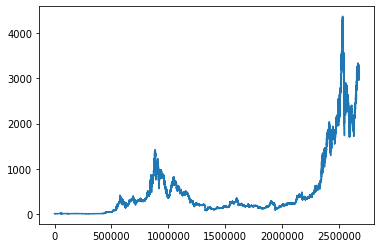

In [4]:
# Plot chart
plt.plot(chart['Open'])

## Generate feature matrix
The feature matrix contains for every price in the chart the growth since the last 1, 2, 4, 8, ..., 524288 prices. These are the features. Furthermore, it contains for every price in the chart the growth till the next 1, 2, 4, 8, ..., 524288 prices. The latter numbers are no features but they can be used as labels for training to predict the price in 1, 2, 4, 8, ..., 524288 prices.

In [5]:
def generateFeatureMatrix(chart):
    
    date = []
    price = []
    last_1 = []
    last_2 = []
    last_4 = []
    last_8 = []
    last_16 = []
    last_32 = []
    last_64 = []
    last_128 = []
    last_256 = []
    last_512 = []
    last_1024 = []
    last_2048 = []
    last_4096 = []
    last_8192 = []
    last_16348 = []
    last_32768 = []
    last_65536 = []
    last_131072 = []
    last_262144 = []
    last_524288 = []
    next_1 = []
    next_2 = []
    next_4 = []
    next_8 = []
    next_16 = []
    next_32 = []
    next_64 = []
    next_128 = []
    next_256 = []
    next_512 = []
    next_1024 = []
    next_2048 = []
    next_4096 = []
    next_8192 = []
    next_16348 = []
    next_32768 = []
    next_65536 = []
    next_131072 = []
    next_262144 = []
    next_524288 = []
    
    i = 0

    rows = chart.shape[0]
    print("Rows:", rows)
    
    # Go through all rows and calculate for each row the growth since or till other prices before or after the current row
    i = 0
    while i < rows:
        if(i % 10000 == 0): print("Row number:", i) # Write every 10000th row index to show progress
        date.append(chart.iloc[i, 0])
        current_price = chart.iloc[i, 1]
        price.append(current_price)
        
        value = np.nan
        if i > 0:
            value = current_price / chart.iloc[i - 1, 1]
            if feature_matrix_logarithmized:
                value = np.log(value)
        last_1.append(value)

        value = np.nan
        if i > 1:
            value = current_price / chart.iloc[i - 2, 1]
            if feature_matrix_logarithmized:
                value = np.log(value)
        last_2.append(value)

        value = np.nan
        if i > 3:
            value = current_price / chart.iloc[i - 4, 1]
            if feature_matrix_logarithmized:
                value = np.log(value)
        last_4.append(value)

        value = np.nan
        if i > 7:
            value = current_price / chart.iloc[i - 8, 1]
            if feature_matrix_logarithmized:
                value = np.log(value)
        last_8.append(value)
        
        value = np.nan
        if i > 15:
            value = current_price / chart.iloc[i - 16, 1]
            if feature_matrix_logarithmized:
                value = np.log(value)
        last_16.append(value)
        
        value = np.nan
        if i > 31:
            value = current_price / chart.iloc[i - 32, 1]
            if feature_matrix_logarithmized:
                value = np.log(value)
        last_32.append(value)
        
        value = np.nan
        if i > 63:
            value = current_price / chart.iloc[i - 64, 1]
            if feature_matrix_logarithmized:
                value = np.log(value)
        last_64.append(value)
        
        value = np.nan
        if i > 127:
            value = current_price / chart.iloc[i - 128, 1]
            if feature_matrix_logarithmized:
                value = np.log(value)
        last_128.append(value)
        
        value = np.nan
        if i > 255:
            value = current_price / chart.iloc[i - 256, 1]
            if feature_matrix_logarithmized:
                value = np.log(value)
        last_256.append(value)
        
        value = np.nan
        if i > 511:
            value = current_price / chart.iloc[i - 512, 1]
            if feature_matrix_logarithmized:
                value = np.log(value)
        last_512.append(value)
        
        value = np.nan
        if i > 1023:
            value = current_price / chart.iloc[i - 1024, 1]
            if feature_matrix_logarithmized:
                value = np.log(value)
        last_1024.append(value)
        
        value = np.nan
        if i > 2047:
            value = current_price / chart.iloc[i - 2048, 1]
            if feature_matrix_logarithmized:
                value = np.log(value)
        last_2048.append(value)
        
        value = np.nan
        if i > 4095:
            value = current_price / chart.iloc[i - 4096, 1]
            if feature_matrix_logarithmized:
                value = np.log(value)
        last_4096.append(value)
        
        value = np.nan
        if i > 8191:
            value = current_price / chart.iloc[i - 8192, 1]
            if feature_matrix_logarithmized:
                value = np.log(value)
        last_8192.append(value)
        
        value = np.nan
        if i > 16347:
            value = current_price / chart.iloc[i - 16348, 1]
            if feature_matrix_logarithmized:
                value = np.log(value)
        last_16348.append(value)
        
        value = np.nan
        if i > 32767:
            value = current_price / chart.iloc[i - 32768, 1]
            if feature_matrix_logarithmized:
                value = np.log(value)
        last_32768.append(value)

        value = np.nan
        if i > 65535:
            value = current_price / chart.iloc[i - 65536, 1]
            if feature_matrix_logarithmized:
                value = np.log(value)
        last_65536.append(value)

        value = np.nan
        if i > 131071:
            value = current_price / chart.iloc[i - 131072, 1]
            if feature_matrix_logarithmized:
                value = np.log(value)
        last_131072.append(value)

        value = np.nan
        if i > 262143:
            value = current_price / chart.iloc[i - 262144, 1]
            if feature_matrix_logarithmized:
                value = np.log(value)
        last_262144.append(value)

        value = np.nan
        if i > 524287:
            value = current_price / chart.iloc[i - 524288, 1]
            if feature_matrix_logarithmized:
                value = np.log(value)
        last_524288.append(value)

        value = np.nan
        if i < (rows - 1):
            value = chart.iloc[i + 1, 1] / current_price
            if feature_matrix_logarithmized:
                value = np.log(value)
        next_1.append(value)        
        
        value = np.nan
        if i < (rows - 2):
            value = chart.iloc[i + 2, 1] / current_price
            if feature_matrix_logarithmized:
                value = np.log(value)
        next_2.append(value)        
        
        value = np.nan
        if i < (rows - 4):
            value = chart.iloc[i + 4, 1] / current_price
            if feature_matrix_logarithmized:
                value = np.log(value)
        next_4.append(value)        
        
        value = np.nan
        if i < (rows - 8):
            value = chart.iloc[i + 8, 1] / current_price
            if feature_matrix_logarithmized:
                value = np.log(value)
        next_8.append(value)        
        
        value = np.nan
        if i < (rows - 16):
            value = chart.iloc[i + 16, 1] / current_price
            if feature_matrix_logarithmized:
                value = np.log(value)
        next_16.append(value)        
        
        value = np.nan
        if i < (rows - 32):
            value = chart.iloc[i + 32, 1] / current_price
            if feature_matrix_logarithmized:
                value = np.log(value)
        next_32.append(value)        
        
        value = np.nan
        if i < (rows - 64):
            value = chart.iloc[i + 64, 1] / current_price
            if feature_matrix_logarithmized:
                value = np.log(value)
        next_64.append(value)        
        
        value = np.nan
        if i < (rows - 128):
            value = chart.iloc[i + 128, 1] / current_price
            if feature_matrix_logarithmized:
                value = np.log(value)
        next_128.append(value)        
        
        value = np.nan
        if i < (rows - 256):
            value = chart.iloc[i + 256, 1] / current_price
            if feature_matrix_logarithmized:
                value = np.log(value)
        next_256.append(value)        
        
        value = np.nan
        if i < (rows - 512):
            value = chart.iloc[i + 512, 1] / current_price
            if feature_matrix_logarithmized:
                value = np.log(value)
        next_512.append(value)        
        
        value = np.nan
        if i < (rows - 1024):
            value = chart.iloc[i + 1024, 1] / current_price
            if feature_matrix_logarithmized:
                value = np.log(value)
        next_1024.append(value)        
        
        value = np.nan
        if i < (rows - 2048):
            value = chart.iloc[i + 2048, 1] / current_price
            if feature_matrix_logarithmized:
                value = np.log(value)
        next_2048.append(value)        
        
        value = np.nan
        if i < (rows - 4096):
            value = chart.iloc[i + 4096, 1] / current_price
            if feature_matrix_logarithmized:
                value = np.log(value)
        next_4096.append(value)        
        
        value = np.nan
        if i < (rows - 8192):
            value = chart.iloc[i + 8192, 1] / current_price
            if feature_matrix_logarithmized:
                value = np.log(value)
        next_8192.append(value)        
        
        value = np.nan
        if i < (rows - 16348):
            value = chart.iloc[i + 16348, 1] / current_price
            if feature_matrix_logarithmized:
                value = np.log(value)
        next_16348.append(value)        
        
        value = np.nan
        if i < (rows - 32768):
            value = chart.iloc[i + 32768, 1] / current_price
            if feature_matrix_logarithmized:
                value = np.log(value)
        next_32768.append(value)        
        
        value = np.nan
        if i < (rows - 65536):
            value = chart.iloc[i + 65536, 1] / current_price
            if feature_matrix_logarithmized:
                value = np.log(value)
        next_65536.append(value)        
        
        value = np.nan
        if i < (rows - 131072):
            value = chart.iloc[i + 131072, 1] / current_price
            if feature_matrix_logarithmized:
                value = np.log(value)
        next_131072.append(value)        
        
        value = np.nan
        if i < (rows - 262144):
            value = chart.iloc[i + 262144, 1] / current_price
            if feature_matrix_logarithmized:
                value = np.log(value)
        next_262144.append(value)        
        
        value = np.nan
        if i < (rows - 524288):
            value = chart.iloc[i + 524288, 1] / current_price
            if feature_matrix_logarithmized:
                value = np.log(value)
        next_524288.append(value)        
        
        i+=1   

    # Create the features matrix from the previously created lists
    feature_matrix = pd.DataFrame(list(zip(date, last_131072, last_65536, last_32768, last_16348, last_8192, last_4096, last_2048, last_1024, last_512, last_256, last_128, last_64, last_32, last_16, last_8, last_4, last_2, last_1, price, next_1, next_2, next_4, next_8, next_16, next_32, next_64, next_128, next_256, next_512, next_1024, next_2048, next_4096, next_8192, next_16348, next_32768, next_65536, next_131072, next_262144, next_524288)), columns =['Date', 'Last131072', 'Last65536', 'Last32768', 'Last16348', 'Last8192', 'Last4096', 'Last2048', 'Last1024', 'Last512', 'Last256', 'Last128', 'Last64', 'Last32', 'Last16', 'Last8', 'Last4', 'Last2', 'Last1', 'Price', 'Next1', 'Next2', 'Next4', 'Next8', 'Next16', 'Next32', 'Next64', 'Next128', 'Next256', 'Next512', 'Next1024', 'Next2048', 'Next4096', 'Next8192', 'Next16348', 'Next32768', 'Next65536', 'Next131072', 'Next262144', 'Next524288'])            

    return feature_matrix

In [6]:
# Depending on the parameters, create and save or load a feature matrix (pickle file format)
if create_new_feature_matrix:
    # Generate the feature matrix
    feature_matrix = generateFeatureMatrix(chart)
    feature_matrix.to_pickle(feature_matrix_name + '.pickle')
else:
    # Load the feature matrix
    feature_matrix = pd.read_pickle(feature_matrix_name + '.pickle')

Rows: 2673677
Row number: 0
Row number: 10000
Row number: 20000
Row number: 30000
Row number: 40000
Row number: 50000
Row number: 60000
Row number: 70000
Row number: 80000
Row number: 90000
Row number: 100000
Row number: 110000
Row number: 120000
Row number: 130000
Row number: 140000
Row number: 150000
Row number: 160000
Row number: 170000
Row number: 180000
Row number: 190000
Row number: 200000
Row number: 210000
Row number: 220000
Row number: 230000
Row number: 240000
Row number: 250000
Row number: 260000
Row number: 270000
Row number: 280000
Row number: 290000
Row number: 300000
Row number: 310000
Row number: 320000
Row number: 330000
Row number: 340000
Row number: 350000
Row number: 360000
Row number: 370000
Row number: 380000
Row number: 390000
Row number: 400000
Row number: 410000
Row number: 420000
Row number: 430000
Row number: 440000
Row number: 450000
Row number: 460000
Row number: 470000
Row number: 480000
Row number: 490000
Row number: 500000
Row number: 510000
Row number: 

In [7]:
# Show feature matrix
feature_matrix.head()

,Date,Last131072,Last65536,Last32768,Last16348,Last8192,Last4096,Last2048,Last1024,Last512,...,Next1024,Next2048,Next4096,Next8192,Next16348,Next32768,Next65536,Next131072,Next262144,Next524288
0,2016-05-09 13:33:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.248461,-0.214845,-0.138305,-0.126887,0.155578,0.157716,0.160559,-0.076161,-0.077061,2.014903
1,2016-05-09 13:34:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.066140,-0.032523,0.044017,0.055435,0.337900,0.340037,0.342880,0.106160,0.105261,2.197113
2,2016-05-09 13:35:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.066140,-0.032523,0.044017,0.055435,0.337900,0.340037,0.337186,0.106160,0.105261,2.196113
3,2016-05-09 13:36:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.066140,-0.032523,0.044017,0.055435,0.337900,0.340037,0.337186,0.106160,0.105261,2.195445
4,2016-05-09 13:37:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.066140,-0.032523,0.044017,0.055435,0.337900,0.340037,0.337186,0.106160,0.105261,2.196335


In [8]:
# Copy feature matrix
feature_matrix_reduced=feature_matrix

# The next steps must be parameterized according to what shall be predicted (e.g., the price in 512 cycles)

# Reduce copied matrix by removing all rows with an empty field in the specified row
feature_matrix_reduced=feature_matrix_reduced.dropna(subset=['Last131072'], axis=0)

# Reduce copied matrix by removing all rows with an empty field in the specified row
feature_matrix_reduced=feature_matrix_reduced.dropna(subset=[prediction_label], axis=0)

# Build the final feature matrix
feature_matrix_reduced = feature_matrix_reduced[['Last131072', 'Last65536', 'Last32768', 'Last16348', 'Last8192', 'Last4096', 'Last2048', 'Last1024', 'Last512', 'Last256', 'Last128', 'Last64', 'Last32', 'Last16', 'Last8', 'Last4', 'Last2', 'Last1', 'Price', prediction_label]]
feature_matrix_reduced.head(10)

,Last131072,Last65536,Last32768,Last16348,Last8192,Last4096,Last2048,Last1024,Last512,Last256,Last128,Last64,Last32,Last16,Last8,Last4,Last2,Last1,Price,Next8192
131072,-0.076161,-0.236720,-0.067793,-0.156973,0.224944,-0.015172,0.01176,0.017234,0.0009,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.12,0.047419
131073,0.106160,-0.236720,-0.067793,-0.156973,0.224944,-0.015172,0.01176,0.017234,0.0009,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.12,0.047419
131074,0.106160,-0.231026,-0.067793,-0.156973,0.224944,-0.015172,0.01176,0.017234,0.0009,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.12,0.047419
131075,0.106160,-0.231026,-0.067793,-0.156973,0.230590,-0.015172,0.01176,0.017234,0.0009,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.12,0.047419
131076,0.106160,-0.231026,-0.067793,-0.156973,0.212632,-0.015172,0.01176,0.017234,0.0009,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.12,0.047419
131077,0.106160,-0.231026,-0.067793,-0.156973,0.212632,-0.015172,0.01176,0.017234,0.0009,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.12,0.047419
131078,0.106160,-0.231026,-0.067793,-0.156973,0.212632,-0.015172,0.01176,0.017234,0.0009,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.12,0.047419
131079,0.106160,-0.231026,-0.067793,-0.151578,0.212632,-0.015172,0.01176,0.017234,0.0009,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.12,0.047419
131080,0.106160,-0.231026,-0.067793,-0.151578,0.232858,-0.015172,0.01176,0.017234,0.0009,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.12,0.047419
131081,0.106160,-0.231026,-0.067793,-0.151578,0.232858,-0.015172,0.01176,0.017234,0.0009,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.12,0.047419


In [9]:
# Create a training set
if use_last_fraction_test_set:
    train_dataset = feature_matrix_reduced.head(int(feature_matrix_reduced.shape[0] * train_set_fraction))
else:
    train_dataset = feature_matrix_reduced.sample(frac=train_set_fraction, random_state=42)
    
# Create a test set by taking all rows whixch are not part of the training set
test_dataset = feature_matrix_reduced.drop(train_dataset.index)

# Randomize training set
train_dataset = train_dataset.sample(frac=1.0, random_state=42)

In [10]:
# Create the labels for the training set (Note: The label column is removed from the training set)
train_labels = train_dataset.pop(prediction_label)

# Create the labels for the test set (Note: The label column is removed from the test set)
test_labels = test_dataset.pop(prediction_label)

In [11]:
# Create and show statistics on the train set
train_stats = train_dataset.describe()
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Last131072,2280971.0,0.247159,0.745366,-1.317227,-0.248058,0.133910,0.603861,2.833772
Last65536,2280971.0,0.136814,0.491287,-1.051766,-0.205878,0.087372,0.417754,1.913344
Last32768,2280971.0,0.070364,0.328030,-1.105042,-0.134700,0.043571,0.256819,1.401606
Last16348,2280971.0,0.036211,0.217072,-0.950704,-0.079637,0.025180,0.137927,1.038842
Last8192,2280971.0,0.018429,0.146572,-1.012051,-0.050155,0.012452,0.086859,0.979535
Last4096,2280971.0,0.009184,0.100360,-0.883959,-0.034470,0.005112,0.053290,0.586518
Last2048,2280971.0,0.004620,0.070752,-0.785098,-0.023724,0.002723,0.034079,0.481727
Last1024,2280971.0,0.002315,0.048551,-0.724474,-0.016864,0.001220,0.022473,0.389399
Last512,2280971.0,0.001157,0.033992,-0.655142,-0.011971,0.000701,0.014749,0.419598
Last256,2280971.0,0.000578,0.024691,-0.669670,-0.008231,0.000146,0.009684,0.444258


In [12]:
def norm(x):
    '''
    OUTPUT:
    Normed row values (normed values have typically benefits for machine learning)
    '''
    return (x - train_stats['mean']) / train_stats['std']

normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

## Create and train the model

In [13]:
def build_model():
    '''
    OUTPUT:
    model
    
    Description:
    Build the model
    '''
    model = keras.Sequential([
        layers.Dense(32, activation=tf.nn.relu, input_shape=[len(train_dataset.keys())]),
        layers.Dense(32, activation=tf.nn.relu),
        layers.Dense(1)
    ])
    
    optimizer = tf.keras.optimizers.RMSprop(0.001)
    
    model.compile(loss='mse',
                  optimizer=optimizer,
                  metrics=['mae', 'mse'])
    return model

# Build the model
model = build_model()

In [14]:
# Summarize the model
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                640       
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 1,729
Trainable params: 1,729
Non-trainable params: 0
_________________________________________________________________


In [15]:
# Show example batch (untrained, just used to check whether the model fits)
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

array([[-0.51412636],
       [-0.21633148],
       [-0.4920037 ],
       [-0.02316385],
       [-0.15666777],
       [-0.45389855],
       [-0.7321553 ],
       [ 0.48040706],
       [ 0.08075795],
       [-0.28087458]], dtype=float32)

In [16]:
# Show example batch
example_batch.head()

,Last131072,Last65536,Last32768,Last16348,Last8192,Last4096,Last2048,Last1024,Last512,Last256,Last128,Last64,Last32,Last16,Last8,Last4,Last2,Last1,Price
1689101,-0.873980,-0.642738,-0.287991,0.010807,-0.056597,-0.180471,-0.127355,-0.280422,0.288929,-0.427464,0.137829,-0.103216,0.015681,-0.052867,-0.057779,0.208326,-0.272980,-0.001167,-0.427757
1084775,-0.886258,-0.091145,-1.097908,-1.205047,-0.324658,-0.185455,-0.185434,-0.199650,-0.405517,-0.577907,-0.078235,-0.758630,-0.715303,-0.053093,0.617321,0.035761,0.004932,0.007972,0.849834
1818612,-0.675504,-0.795796,-0.453709,-0.391859,-0.484209,-0.264486,-0.083246,-0.225802,-0.255470,-0.285648,-0.074274,-0.042818,0.088088,0.025093,-0.058544,-0.002439,-0.001692,-0.001167,-0.553105
2369410,1.335075,1.400152,1.558831,0.297187,0.573580,0.553955,-0.088186,-1.591037,-0.999555,0.157939,1.647157,0.085563,0.330538,0.609012,0.254668,-0.856389,0.566311,0.337398,3.324284
1982681,-0.150495,-1.030571,0.339056,0.193854,-0.587941,-0.038177,0.222340,0.077040,-0.653752,-0.506939,-0.715579,0.075397,-0.100094,-0.132126,-0.806692,-0.688288,-0.953111,-0.001167,-0.501048


In [17]:
# Create cloass to show dots to visualize the progress (training takes long; shows that the program has not crashed)
class PrintDots(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')

In [18]:
# Load model or create a new one and save it together with training history (use comment/uncomment)

if create_new_model:
    # Train the model and return a history
    history = model.fit(
        normed_train_data, train_labels,
        epochs=number_of_epochs, validation_split = 0.8, verbose=0,
        callbacks=[PrintDots()])

    # Save model
    model.save(model_name)
    history = pd.DataFrame(history.history)
    history.insert(0, 'epoch', range(0, 0 + len(history)))
    history.to_pickle(history_name + '.pickle')
    
else:
    # Load model
    model = keras.models.load_model(model_name)
    history = pd.read_pickle(history_name + '.pickle')


..................................................INFO:tensorflow:Assets written to: model_ETH_concat_chart_50epochs_Next8192\assets


## Show training results

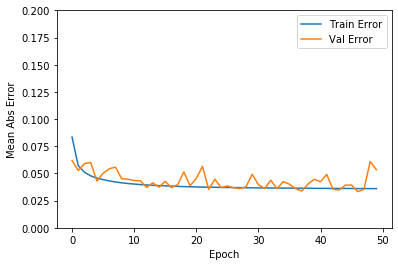

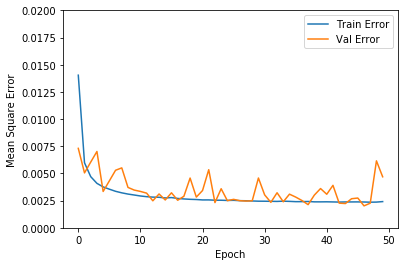

In [19]:
def plot_history(history):
    '''
    Description:
    Plot history of the training
    '''

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error')
    plt.plot(history['epoch'], history['mae'],
            label='Train Error')    
    plt.plot(history['epoch'], history['val_mae'],
            label='Val Error')
    plt.legend()
    plt.ylim([0,0.2])

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error')
    plt.plot(history['epoch'], history['mse'],
            label='Train Error')
    plt.plot(history['epoch'], history['val_mse'],
            label='Val Error')
    plt.legend()
    plt.ylim([0,0.02])
    
plot_history(history)

In [20]:
# Store the predicted values of train and test data
train_predictions=model.predict(normed_train_data[:normed_train_data.shape[0]])
test_predictions=model.predict(normed_test_data[:normed_test_data.shape[0]])

In [21]:
def calc_binary_prediction_rate(predictions, labels):
    '''
    INPUT:
    predictions - array of predicted values
    labels - pandas series of labels
    
    OUTPUT:
    binary_prediction_rate - float
    number_of_positives - int
    number_of_negatives - int
    
    Description:
    Returns fraction of cases in which the trend (increase or decrease) fits between predicted value and label.
    '''

    binary_prediction_rate = 0
    i = 0
    number_of_positives = 0
    number_of_negatives = 0
    
    if feature_matrix_logarithmized:
        while i < predictions.shape[0]:
            if (predictions[i][0] < 0.0 and labels.iloc[i] < 0.0) or (predictions[i][0] >= 0.0 and labels.iloc[i] >= 0.0):
                binary_prediction_rate+=1
            if labels.iloc[i] >= 0.0:
                number_of_positives+=1
            else:
                number_of_negatives+=1
            i+=1        
    else:
        while i < predictions.shape[0]:
            if (predictions[i][0] < 1.0 and labels.iloc[i] < 1.0) or (predictions[i][0] >= 1.0 and labels.iloc[i] >= 1.0):
                binary_prediction_rate+=1
            if labels.iloc[i] >= 1.0:
                number_of_positives+=1
            else:
                number_of_negatives+=1
            i+=1
        
    print("Correct binary prediction number: ", binary_prediction_rate)
    print("Overall number:                   ", predictions.shape[0])
    
    binary_prediction_rate = binary_prediction_rate / predictions.shape[0]
    
    return binary_prediction_rate, number_of_positives, number_of_negatives
    

In [22]:
train_prediction_rate, train_number_of_positives, train_number_of_negatives = calc_binary_prediction_rate(train_predictions, train_labels)

Correct binary prediction number:  1816411
Overall number:                    2280971


In [23]:
test_prediction_rate, test_number_of_positives, test_number_of_negatives = calc_binary_prediction_rate(test_predictions, test_labels)

Correct binary prediction number:  110969
Overall number:                    253442


In [24]:
print("Training set size:", train_dataset.shape[0])
print("Training set #POS:", train_number_of_positives)
print("Training set #NEG:", train_number_of_negatives)
print("Training prediction percentage:", train_prediction_rate * 100, "%")
print("---")
print("Test set size:", test_dataset.shape[0])
print("Test set #POS:", test_number_of_positives)
print("Test set #NEG:", test_number_of_negatives)
print("Test prediction percentage: ", test_prediction_rate * 100, "%")

Training set size: 2280971
Training set #POS: 1263116
Training set #NEG: 1017855
Training prediction percentage: 79.6332351441557 %
---
Test set size: 253442
Test set #POS: 151404
Test set #NEG: 102038
Test prediction percentage:  43.78477126916612 %
